# Prototype Evaluation

Author: Frankie Inguanez<br/>
Date: 16/01/2023<br /><br />

An evalation of the prototype.

In [ ]:
class SudokuExecutor:
    def __init__(self, puzzlesFileName: str, trackingFileName:str, statsFileName: str, errorsFileName: str, offset: int, limit: int):
        self.puzzlesFileName=puzzlesFileName
        self.trackingFileName=trackingFileName
        self.statsFileName=statsFileName
        self.errorsFileName=errorsFileName
        self.offset=offset
        self.limit=limit

class SudokuConfig:
    def __init__(self, searchMode: int, guessMode: int, tracking: bool):
        self.searchMode=searchMode
        self.guessMode=guessMode
        self.tracking=tracking

class SudokuStats:
    def __init__(self):
        self.guesses = 0
        self.backtracks = 0
        self.executionTime = None
        self.unknowns = 0

    def incrementGuesses(self):
        self.guesses += 1

    def incrementBacktracks(self):
        self.backtracks += 1

    def registerExecutionTime(self, executionTime):
        self.executionTime=executionTime

    def setUnknowns(self, zeros:int):
        self.unknowns=zeros

def getFileLineCount(fileName: str):
    """
    Get number of lines in a file.
    Arguments:
        fileName: the name of the file to process.
    """
    import mmap

    lines = 0
    with open(fileName, "r+", encoding="utf-8") as f:
        bf = mmap.mmap(f.fileno(), 0)

        while bf.readline():
            lines += 1

    return lines
    
def saveError(error, errorsFileName: str):
    """
    Saves an error/exception that is raised.
    Arguments:
        error: the Exception that is raised.
        errorsFileName: the file name where the error will be saved.
    """
    try:
        with open(errorsFileName, "a", encoding="utf-8") as ef:
            ef.write("Encountered error:\n{}\n{}\n{}\n\n".format(type(error), error.args, error))
    except Exception as e:
        # Failed to save error to file
        print("Failed to save original error to file due to:\n{}\n{}\n{}\n\n".format(type(e), e.args, e))
        print("Original error:\n{}\n{}\n{}\n\n".format(type(error), error.args, error))
        
def to2DArray(n: str):
    """
    Convert a string to a 2D 9x9 array.
    Arguments:
        n: an 81 digits in string format.
    """
    return [list(map(int, n[i:i+9])) for i in range(0, 81, 9)]

def toStr(puzzle):
    """
    Converts a puzzle to a string.
    Arguments:
        puzzle: a 2 dimensional array representing the 9x9 puzzle. 
    """
    r = ""

    for row in puzzle:
        r += "".join(map(str, row))

    return r

def getColValues(puzzle, col: int):
    """
    Get column values.
    Arguments:
        puzzle: a 2 dimensional array representing the 9x9 puzzle. 
        col: the column number.
    """
    lst = []
    for row in puzzle:
        lst.append(row[col])

    return lst;

def getBoxValues(puzzle, box: int):
    """
    Get box values. Boxes are 3x3 sub-grids enumerates from top left in a raster fashion
    0, 1, 2
    3, 4, 5
    6, 7, 8
    Arguments:
        puzzle: a 2 dimensional array representing the 9x9 puzzle.
        box: the box identification number.
    """
    return [puzzle[x][y] for x in range((box//3)*3,((box//3)*3)+3) for y in range((box%3)*3, ((box%3)*3)+3)]

def checkList(lst: list):
    """
    Checks if a list contains all numbers from 1 to 9.
    Arguments:
        lst: the list of numbers.
    """
    return set(lst) == set(range(1,10))

def isSolved(puzzle):
    """
    Check if a puzzle has been solved.
    Arguments:
        puzzle: a 2 dimensional array representing the 9x9 puzzle.
    """

    # Check rows
    for row in puzzle:
        if not checkList(row):
            return False

    # Check columns
    for i in range(0,9):
        if not checkList(getColValues(puzzle, i)):
            return False;

    # Check box
    for i in range(0,9):
        if not checkList(getBoxValues(puzzle, i)):
            return False;

    return True

def isValid(puzzle, num: int, pos):
    """
    Checks if a number can be added to a specific position
    Arguments:
        puzzle: a 2 dimensional array representing the 9x9 puzzle.
        num: the number to insert.
        pos: the row and column position to place the digit.
    """
    
    # Check the row
    for i in range(len(puzzle[0])):
        if puzzle[pos[0]][i]==num and pos[1] != i:
            return False

    # Check the column
    for i in range(len(puzzle[1])):
        if puzzle[i][pos[1]]==num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if puzzle[i][j] == num and (i,j) != pos:
                return False

    return True

In [ ]:
def findRandom(puzzle):
    """
    Finds the next empty cell in a random fashion.
    """
    import random

    for row in random.sample(range(0,9),9):
        for col in random.sample(range(0,9),9):
            if puzzle[row][col] == 0:
                return (row, col)

    return None

def findByRow(puzzle):
    """
    Finds the next empty cell in a raster fashion, row by row.
    Arguments:
        puzzle: a 9x9 sudoku puzzle
    """
    
    for row in range(len(puzzle)):
        for col in range(len(puzzle[0])):
            if puzzle[row][col] == 0:
                return (row, col)
            
    return None

def findByCol(puzzle):
    """
    Finds the next empty cell in a column order.
    Arguments:
        puzzle: a 9x9 sudoku puzzle
    """
    for col in range(0,9):
        for row in range(len(puzzle)):
            if puzzle[row][col]==0:
                return (row, col)
    
    return None

def findByBox(puzzle, mode):
    """
    Finds the next empty cell searching first by box then by row.
    Arguments:
        puzzle: a 9x9 sudoku puzzle
        mode:   4 searches for boxes sequentially, 
                5 searches for boxes in a zig-zag fashion, 
                6 searches for boxes in spiral fashion, 
                7 searches for boxes in a semi zig-zag fashion,
                8 searches for boxes randomly
    """
    import random

    if mode==4:
        boxes=range(0,9)
    elif mode==5:
        boxes=[0,1,2,5,4,3,6,7,8]
    elif mode==6:
        boxes=[0,1,2,5,8,7,6,3,4]
    elif mode==7:
        boxes=[0,1,4,3,6,7,8,5,2]
    elif mode==8:
        boxes=random.sample(range(0,9),9)
    elif mode==9:
        boxes=[0,4,8,1,2,3,5,6,7]

    for box in boxes:
        for row in range((box//3)*3,((box//3)*3)+3):
            for col in range((box%3)*3, ((box%3)*3)+3):
                if puzzle[row][col]==0:
                    return (row, col)

    return None

def findEmpty(puzzle, searchMode):
    """
    Finds the next empty cell in a 9x9 sudoku puzzle.
    Arguments:
        puzzle: the 9x9 sudoku puzzle.
        searchMode: defines how the puzzle is parsed: 
                    1 by row; 
                    2 by col; 
                    3 random;
                    4 by box sequentially; 
                    5 by box in a zig-zag; 
                    6 by box in a spiral; 
                    7 by box in a semi-zig-zag;
                    8 by box randomly;
                    9 by box diagonal;
    """
    if searchMode==1:
        return findByRow(puzzle)
    elif searchMode==2:
        return findByCol(puzzle)
    elif searchMode==3:
        return findRandom(puzzle)
    elif searchMode>=4 and searchMode<=9:
        return findByBox(puzzle, searchMode)
    
    return None

In [ ]:
def getGuesses(puzzle, guessMode):
    """
    Gets numbers to guess.
    Arguments:
        puzzle: the 9x9 sudoku puzzle.
        guessMode: the guessing mode. 1 for sequential, 2 for random.
    """
    import random

    if guessMode==1:
        return range(1,10)
    elif guessMode==2:
        return random.sample(range(1,10),9)

    return None

In [ ]:
def backtracking(board: list, history: list, stats: SudokuStats, config: SudokuConfig):
    """
    Solves a 9x9 sudoku puzzle using backtracking algorithm.
    Arguments:
        board: the 9x9 puzzle to be solved.
        stats: The statistics object to record algorithm.
        searchMode: defines how the puzzle is parsed: 1 by row; 2 by col; 3 by box sequentially; 4 by box in a zig-zag; 5 by box in a spiral; 6 by box in a semi-zig-zag
        guessMode: defines how numbers are guessed: 1 sequentially; 2 randomly
    """
    # Find the next empty cell
    find = findEmpty(board, config.searchMode)

    # If there is no empty cell than puzzle is complete
    if not find:
        return True
    else:
        row, col = find

    # Get numbers to guess and attempt
    for guess in getGuesses(board, config.guessMode):
        if isValid(board, guess, (row, col)):

            # Brute force guess
            stats.incrementGuesses()
            board[row][col] = guess

            if config.tracking:
                history.append(toStr(board))

            # Attempt to solve rest of puzzle with current choice
            if backtracking(board, history, stats, config):
                return True

            # Invalid puzzle so backtrack
            if config.tracking:
                history.remove(toStr(board))
            stats.incrementBacktracks()
            board[row][col] = 0

    return False


In [ ]:
def findRandom(puzzle):
    """
    Finds the next empty cell in a random fashion.
    """
    import random

    for row in random.sample(range(0,9),9):
        for col in random.sample(range(0,9),9):
            if puzzle[row][col] == 0:
                return (row, col)

    return None

def findByRow(puzzle):
    """
    Finds the next empty cell in a raster fashion, row by row.
    Arguments:
        puzzle: a 9x9 sudoku puzzle
    """
    
    for row in range(len(puzzle)):
        for col in range(len(puzzle[0])):
            if puzzle[row][col] == 0:
                return (row, col)
            
    return None

def findByCol(puzzle):
    """
    Finds the next empty cell in a column order.
    Arguments:
        puzzle: a 9x9 sudoku puzzle
    """
    for col in range(0,9):
        for row in range(len(puzzle)):
            if puzzle[row][col]==0:
                return (row, col)
    
    return None

def findByBox(puzzle, mode):
    """
    Finds the next empty cell searching first by box then by row.
    Arguments:
        puzzle: a 9x9 sudoku puzzle
        mode:   4 searches for boxes sequentially, 
                5 searches for boxes in a zig-zag fashion, 
                6 searches for boxes in spiral fashion, 
                7 searches for boxes in a semi zig-zag fashion,
                8 searches for boxes randomly
    """
    import random

    if mode==4:
        boxes=range(0,9)
    elif mode==5:
        boxes=[0,1,2,5,4,3,6,7,8]
    elif mode==6:
        boxes=[0,1,2,5,8,7,6,3,4]
    elif mode==7:
        boxes=[0,1,4,3,6,7,8,5,2]
    elif mode==8:
        boxes=random.sample(range(0,9),9)
    elif mode==9:
        boxes=[0,4,8,1,2,3,5,6,7]

    for box in boxes:
        for row in range((box//3)*3,((box//3)*3)+3):
            for col in range((box%3)*3, ((box%3)*3)+3):
                if puzzle[row][col]==0:
                    return (row, col)

    return None

def findEmpty(puzzle, searchMode):
    """
    Finds the next empty cell in a 9x9 sudoku puzzle.
    Arguments:
        puzzle: the 9x9 sudoku puzzle.
        searchMode: defines how the puzzle is parsed: 
                    1 by row; 
                    2 by col; 
                    3 random;
                    4 by box sequentially; 
                    5 by box in a zig-zag; 
                    6 by box in a spiral; 
                    7 by box in a semi-zig-zag;
                    8 by box randomly;
                    9 by box diagonal;
    """
    if searchMode==1:
        return findByRow(puzzle)
    elif searchMode==2:
        return findByCol(puzzle)
    elif searchMode==3:
        return findRandom(puzzle)
    elif searchMode>=4 and searchMode<=9:
        return findByBox(puzzle, searchMode)
    
    return None

In [ ]:
def getGuesses(puzzle, guessMode):
    """
    Gets numbers to guess.
    Arguments:
        puzzle: the 9x9 sudoku puzzle.
        guessMode: the guessing mode. 1 for sequential, 2 for random.
    """
    import random

    if guessMode==1:
        return range(1,10)
    elif guessMode==2:
        return random.sample(range(1,10),9)

    return None

In [ ]:
def solvePuzzles(executor: SudokuExecutor, config: SudokuConfig):
    """
    Solves puzzles found in a file using backtracking algorithm.
    Arguments:
        puzzlesFileName: file containing puzzles in following format: <id>, <puzzle>, <solution>
        statsFileName: file where statistics shall be saved.
        errorsFileName: file where errors shall be saved.
        limit: the limit number of puzzles to solve.
        searchMode: defines how missing values are searched.
        guessMode: defines how guesses are made.
    """
    import tqdm
    import timeit

    if not executor.limit:
        limit = getFileLineCount(executor.puzzlesFileName)
    else: limit = executor.limit

    i = 1
    hasError = False
    try:
        print("Starting sudoku base solver.")
        
        # Open statistics file
        with open(executor.statsFileName, "w", encoding="utf-8") as sf:
            #Write header row
            sf.write("Puzzle,Solution,Execution Time,Zeros,Guesses,Backtracks\n")

            # Open puzzles and read till limit is reached.
            with open(executor.puzzlesFileName, "r", encoding="utf-8") as pf:
                for line in tqdm.tqdm(pf, total=limit):
                    # Stop at limit
                    if (i>limit):
                        break

                    # Create board and statistics
                    puzzle=line.strip()
                    board = to2DArray(puzzle)
                    
                    stats = SudokuStats();
                    stats.setUnknowns(puzzle.count('0'))
                    stats.registerExecutionTime(timeit.timeit(lambda: backtracking(board, None, stats, config), number=1000))                   
                        
                    # Write statistics
                    sf.write("{},{},{:0.17f},{:0.0f},{:0.0f},{:0.0f}\n"\
                        .format(puzzle, toStr(board), stats.executionTime, stats.unknowns, stats.guesses, stats.backtracks))
                    i+=1

    except Exception as e:
        hasError = True
        saveError(e, executor.errorsFileName)

    print("Operation encountered some errors. Check {} for details or script output above.".format(executor.errorsFileName) \
        if hasError else "Sudoku puzzles solved completed successfully.")
    print("Sudoku solver statistics saved in {}".format(executor.statsFileName))

In [3]:
for s in range(1,9):
    for g in range(1,3):
        config = SudokuConfig(searchMode=s, guessMode=g)

        exec = SudokuExecutor(puzzlesFileName="sudokuDataset.csv",statsFileName="backtracking_search_{:0.0f}_guess_{:0.0f}.csv".format(s,g), \
                            errorsFileName="backtrackingErrors.txt", offset=0, limit=1000)
        solvePuzzles(exec, config)

Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_1_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_1_guess_2.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_2_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_2_guess_2.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_3_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_3_guess_2.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_4_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_4_guess_2.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_5_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_5_guess_2.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_6_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_6_guess_2.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_7_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_7_guess_2.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]


Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_8_guess_1.csv
Starting sudoku base solver.


  0%|          | 0/11 [00:00<?, ?it/s]

Operation encountered some errors. Check backtrackingErrors.txt for details or script output above.
Sudoku solver statistics saved in backtracking_search_8_guess_2.csv


In [100]:
import pandas as pd

stats = pd.DataFrame()

for s in range(1,9):
    for g in range (1,3):
        data = pd.read_csv("backtracking_search_{:0.0f}_guess_{:0.0f}.csv".format(s,g))

        data["algorithm"]="backtracking"
        data["search"]=s
        data["guess"]=g

        if stats.__len__()== 0:
            stats = data
        else:
            stats = pd.concat((stats, data), axis=0)

stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Puzzle          16000 non-null  object 
 1   Solution        16000 non-null  object 
 2   Execution Time  16000 non-null  float64
 3   Zeros           16000 non-null  int64  
 4   Guesses         16000 non-null  int64  
 5   Backtracks      16000 non-null  int64  
 6   algorithm       16000 non-null  object 
 7   search          16000 non-null  int64  
 8   guess           16000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 1.2+ MB


In [101]:
stats[(stats["search"]==1) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean()

Zeros
36    0.007052
37    0.006899
38    0.007495
39    0.007143
40    0.007197
41    0.007680
42    0.007833
43    0.007981
44    0.008552
45    0.008756
46    0.010195
Name: Execution Time, dtype: float64

In [102]:
stats[(stats["search"]==1) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean()

Zeros
36    0.008175
37    0.008381
38    0.008684
39    0.008602
40    0.009085
41    0.011286
42    0.011161
43    0.012665
44    0.014228
45    0.014602
46    0.017266
Name: Execution Time, dtype: float64

In [103]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==1)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==1) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==1) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values

toPlot.info()
print(toPlot)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Zeros       11 non-null     int64  
 1   Sequential  11 non-null     float64
 2   Random      11 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 392.0 bytes
    Zeros  Sequential    Random
0      36    0.007052  0.008175
1      37    0.006899  0.008381
2      38    0.007495  0.008684
3      39    0.007143  0.008602
4      40    0.007197  0.009085
5      41    0.007680  0.011286
6      42    0.007833  0.011161
7      43    0.007981  0.012665
8      44    0.008552  0.014228
9      45    0.008756  0.014602
10     46    0.010195  0.017266


Text(0.5, 1.0, 'Backtracking - By Row - Execution Analysis')

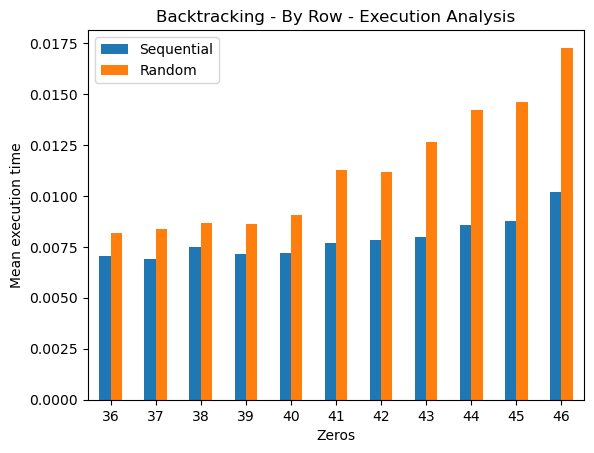

In [104]:
ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - By Row - Execution Analysis")

    Zeros  Sequential    Random
0      36    0.006537  0.007529
1      37    0.006565  0.009421
2      38    0.007046  0.008530
3      39    0.007229  0.008797
4      40    0.007710  0.010010
5      41    0.007830  0.010220
6      42    0.008085  0.010721
7      43    0.008318  0.012313
8      44    0.008104  0.013086
9      45    0.008535  0.014666
10     46    0.009642  0.018729


Text(0.5, 1.0, 'Backtracking - By Column - Execution Analysis')

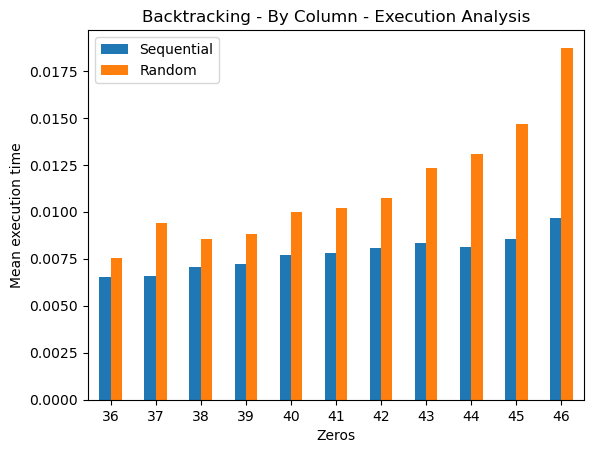

In [105]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==2)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==2) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==2) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - By Column - Execution Analysis")

    Zeros  Sequential    Random
0      36    0.077352  0.123590
1      37    0.089831  0.097702
2      38    0.103602  0.132908
3      39    0.130350  0.162441
4      40    0.178006  0.209198
5      41    0.262204  0.309127
6      42    0.334137  0.421030
7      43    0.526480  0.525014
8      44    1.028337  1.045600
9      45    1.202834  1.571197
10     46    2.679842  3.611422


Text(0.5, 1.0, 'Backtracking - Random - Execution Analysis')

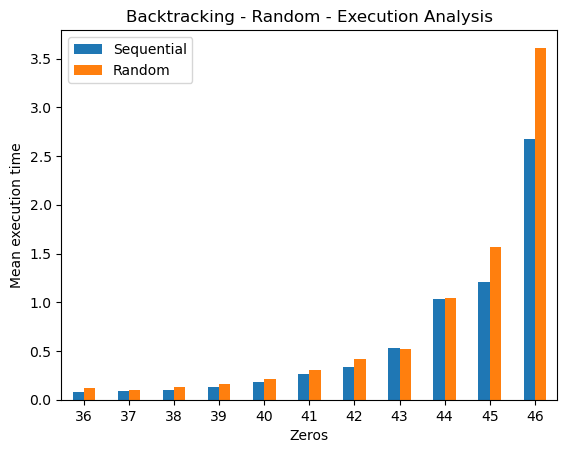

In [106]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==3)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==3) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==3) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - Random - Execution Analysis")

    Zeros  Sequential    Random
0      36    0.015114  0.015649
1      37    0.014859  0.015327
2      38    0.014898  0.016298
3      39    0.014636  0.016985
4      40    0.014708  0.017351
5      41    0.015022  0.018324
6      42    0.015659  0.018629
7      43    0.015440  0.019020
8      44    0.015624  0.020297
9      45    0.016786  0.022733
10     46    0.019408  0.027318


Text(0.5, 1.0, 'Backtracking - Sequential by box - Execution Analysis')

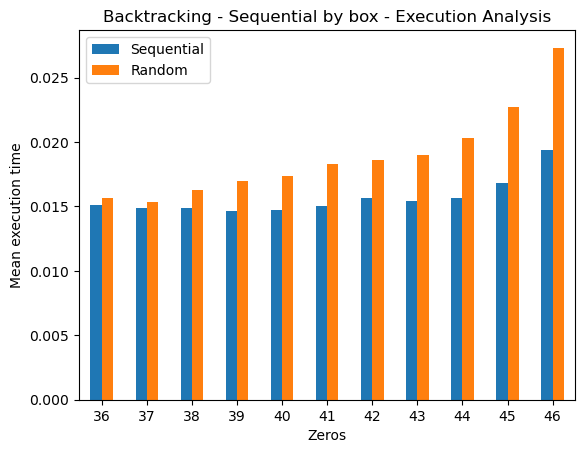

In [107]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==4)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==4) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==4) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - Sequential by box - Execution Analysis")

    Zeros  Sequential    Random
0      36    0.018548  0.016447
1      37    0.013681  0.015972
2      38    0.015438  0.015289
3      39    0.014623  0.015844
4      40    0.014851  0.016639
5      41    0.015598  0.018480
6      42    0.015425  0.017974
7      43    0.016452  0.020316
8      44    0.016803  0.022822
9      45    0.017748  0.022665
10     46    0.018975  0.025100


Text(0.5, 1.0, 'Backtracking - Zig-Zag by box - Execution Analysis')

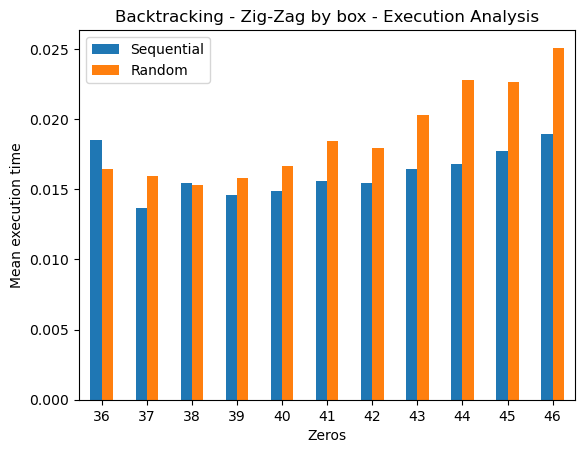

In [108]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==5)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==5) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==5) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - Zig-Zag by box - Execution Analysis")

    Zeros  Sequential    Random
0      36    0.020208  0.021364
1      37    0.014053  0.014569
2      38    0.015258  0.014854
3      39    0.015019  0.015328
4      40    0.015538  0.016579
5      41    0.016106  0.018871
6      42    0.016859  0.020313
7      43    0.016808  0.019586
8      44    0.018009  0.023988
9      45    0.018330  0.023771
10     46    0.020244  0.028318


Text(0.5, 1.0, 'Backtracking - Spiral by box - Execution Analysis')

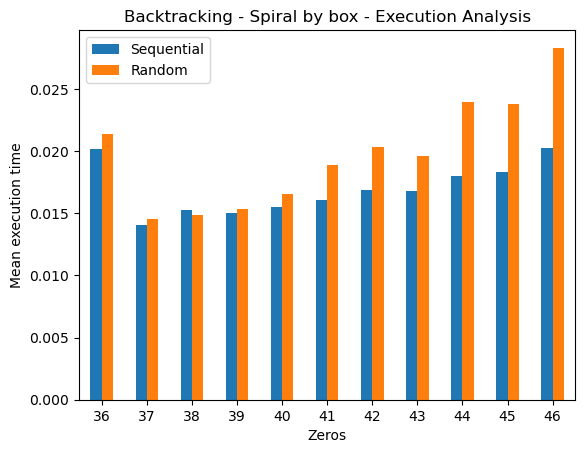

In [109]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==6)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==6) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==6) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - Spiral by box - Execution Analysis")

    Zeros  Sequential    Random
0      36    0.013201  0.015064
1      37    0.013274  0.014037
2      38    0.014270  0.015701
3      39    0.013725  0.015135
4      40    0.013841  0.015730
5      41    0.014317  0.017609
6      42    0.014571  0.016992
7      43    0.015796  0.019643
8      44    0.015182  0.019180
9      45    0.016762  0.022903
10     46    0.017566  0.027101


Text(0.5, 1.0, 'Backtracking - Semi-zig-zag by box - Execution Analysis')

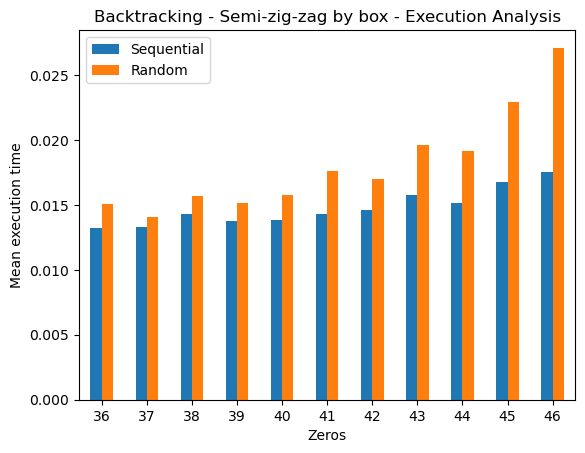

In [110]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==7)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==7) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==7) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - Semi-zig-zag by box - Execution Analysis")

    Zeros  Sequential    Random
0      36    0.022328  0.040430
1      37    0.030069  0.035792
2      38    0.029583  0.038903
3      39    0.031247  0.041481
4      40    0.040015  0.051970
5      41    0.057086  0.068145
6      42    0.062993  0.078795
7      43    0.073699  0.099296
8      44    0.119930  0.147494
9      45    0.129583  0.165549
10     46    0.231161  0.328863


Text(0.5, 1.0, 'Backtracking - Random by box - Execution Analysis')

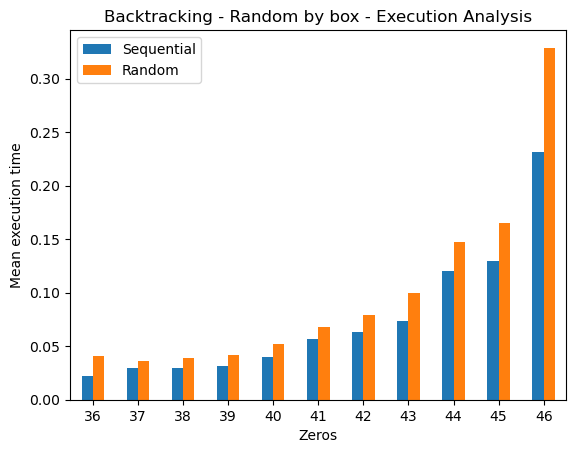

In [111]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==8)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==8) & (stats["guess"]==1)].groupby(by="Zeros")["Execution Time"].mean().values
toPlot["Random"] = stats[(stats["search"]==8) & (stats["guess"]==2)].groupby(by="Zeros")["Execution Time"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean execution time")
ax.set_title("Backtracking - Random by box - Execution Analysis")

    Zeros  Sequential      Random
0      36   39.000000   37.666667
1      37   24.909091   37.454545
2      38   69.681818   82.590909
3      39   38.940299   69.134328
4      40   46.880734  100.082569
5      41   80.811024  197.645669
6      42   90.928000  181.144000
7      43   99.628571  235.035714
8      44  131.108108  299.054054
9      45  155.422857  329.131429
10     46  253.036364  454.209091


Text(0.5, 1.0, 'Backtracking - By Row - Backtracks Analysis')

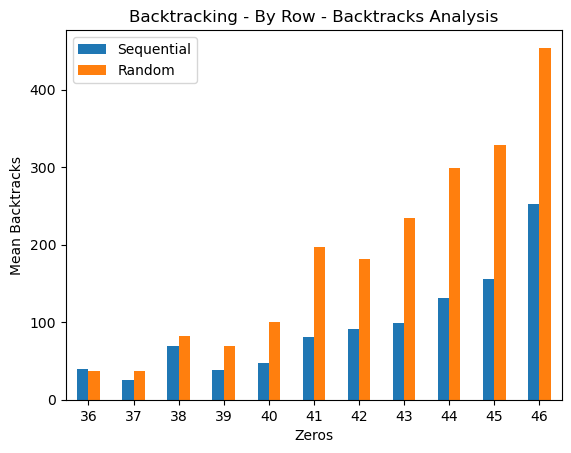

In [112]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==1)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==1) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==1) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - By Row - Backtracks Analysis")

    Zeros  Sequential      Random
0      36   11.666667   20.000000
1      37   12.363636   62.545455
2      38   21.545455   72.227273
3      39   27.641791   67.970149
4      40   49.816514  126.192661
5      41   50.094488  136.811024
6      42   64.728000  154.184000
7      43   75.671429  213.521429
8      44   66.792793  249.666667
9      45  104.691429  330.880000
10     46  168.300000  502.072727


Text(0.5, 1.0, 'Backtracking - By column - Backtracks Analysis')

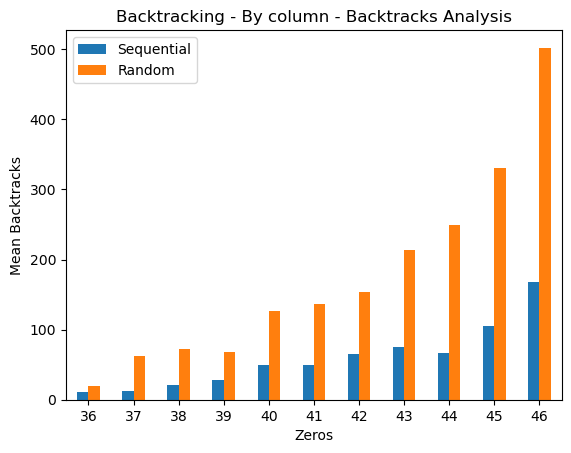

In [113]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==2)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==2) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==2) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - By column - Backtracks Analysis")

    Zeros    Sequential         Random
0      36    434.333333    1112.666667
1      37    885.636364     942.636364
2      38   1345.363636    2052.090909
3      39   2373.522388    2917.373134
4      40   4064.724771    4290.752294
5      41   7122.055118    7248.590551
6      42   9545.808000   10531.008000
7      43  17579.350000   14572.285714
8      44  36423.702703   31640.045045
9      45  43980.022857   46687.028571
10     46  99522.718182  111822.090909


Text(0.5, 1.0, 'Backtracking - Random Search - Backtracks Analysis')

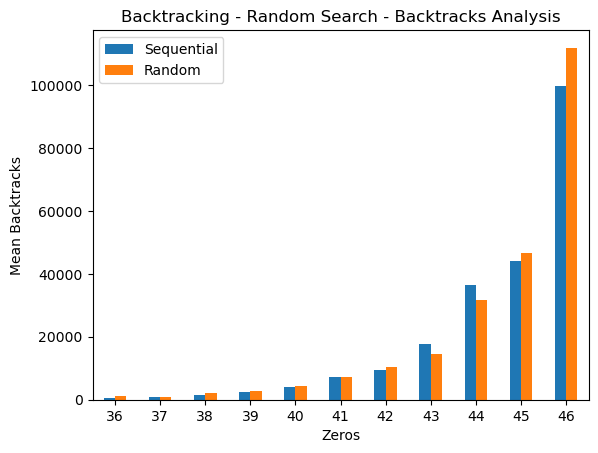

In [114]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==3)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==3) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==3) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - Random Search - Backtracks Analysis")

    Zeros  Sequential      Random
0      36   38.666667   56.000000
1      37   23.090909   41.181818
2      38   64.909091   79.045455
3      39   45.492537  105.820896
4      40   43.559633  121.036697
5      41   73.708661  156.842520
6      42   95.656000  173.304000
7      43   85.235714  201.200000
8      44  112.108108  245.135135
9      45  168.902857  329.262857
10     46  301.109091  483.990909


Text(0.5, 1.0, 'Backtracking - Sequential by box - Backtracks Analysis')

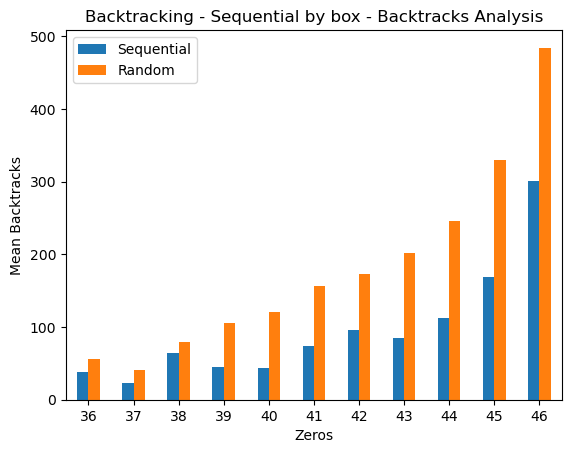

In [115]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==4)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==4) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==4) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - Sequential by box - Backtracks Analysis")

    Zeros  Sequential      Random
0      36  126.333333   11.666667
1      37   19.454545   46.090909
2      38   59.772727   52.272727
3      39   45.776119   70.671642
4      40   55.522936  103.834862
5      41   89.133858  155.818898
6      42   98.648000  152.240000
7      43  133.850000  244.564286
8      44  157.729730  323.675676
9      45  188.354286  331.948571
10     46  250.981818  407.881818


Text(0.5, 1.0, 'Backtracking - Zig-zag by box - Backtracks Analysis')

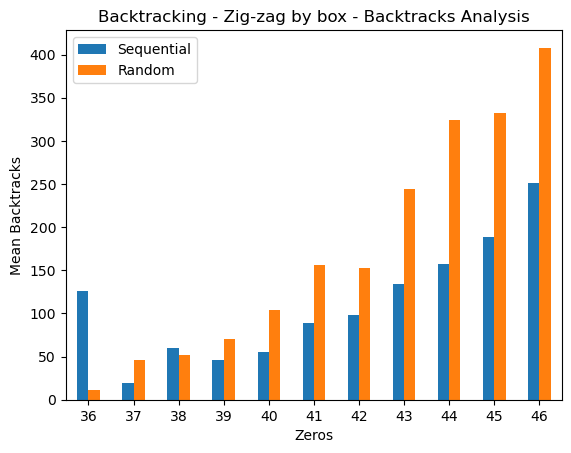

In [116]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==5)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==5) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==5) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - Zig-zag by box - Backtracks Analysis")

    Zeros  Sequential      Random
0      36  308.666667  301.666667
1      37   32.545455   53.181818
2      38   46.227273   63.818182
3      39   55.447761   85.477612
4      40   78.660550  134.486239
5      41  105.826772  214.574803
6      42  152.888000  272.608000
7      43  164.414286  249.235714
8      44  215.468468  416.414414
9      45  221.954286  411.971429
10     46  331.900000  588.545455


Text(0.5, 1.0, 'Backtracking - Spiral by box - Backtracks Analysis')

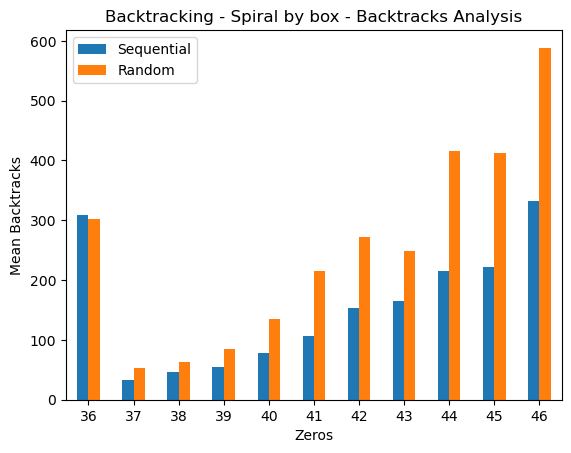

In [117]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==6)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==6) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==6) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - Spiral by box - Backtracks Analysis")

    Zeros  Sequential      Random
0      36   16.000000   71.333333
1      37   16.272727   33.000000
2      38   80.409091  104.818182
3      39   47.089552   74.820896
4      40   50.357798  101.192661
5      41   80.503937  169.220472
6      42   91.992000  150.344000
7      43  159.378571  258.542857
8      44  122.972973  237.000000
9      45  215.417143  391.931429
10     46  256.136364  555.227273


Text(0.5, 1.0, 'Backtracking - Semi-Zig-zag by box - Backtracks Analysis')

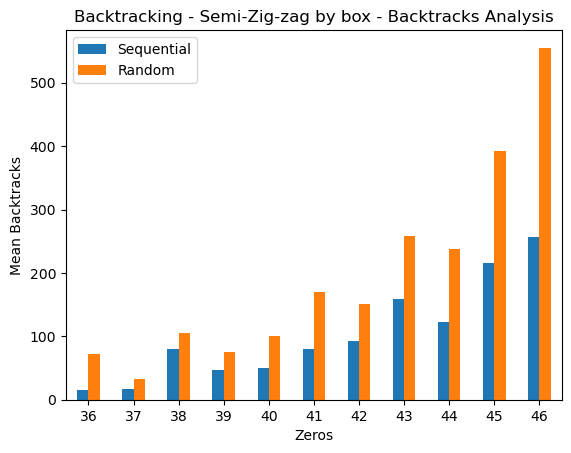

In [118]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==7)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==7) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==7) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - Semi-Zig-zag by box - Backtracks Analysis")

    Zeros    Sequential        Random
0      36    152.666667    797.666667
1      37    527.818182    530.636364
2      38    535.045455    676.000000
3      39    605.134328    729.820896
4      40   1045.256881   1071.944954
5      41   1882.212598   1700.637795
6      42   2159.488000   2107.936000
7      43   2693.507143   2942.078571
8      44   4940.342342   4511.279279
9      45   5459.125714   5229.462857
10     46  10480.690909  11328.263636


Text(0.5, 1.0, 'Backtracking - Random by box - Backtracks Analysis')

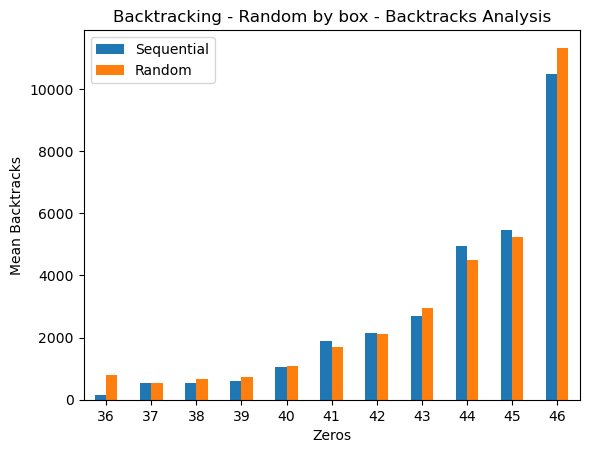

In [119]:
toPlot = pd.DataFrame()
toPlot["Zeros"] = stats[(stats["search"]==8)].groupby(by="Zeros").count().index
toPlot["Sequential"] = stats[(stats["search"]==8) & (stats["guess"]==1)].groupby(by="Zeros")["Backtracks"].mean().values
toPlot["Random"] = stats[(stats["search"]==8) & (stats["guess"]==2)].groupby(by="Zeros")["Backtracks"].mean().values
print(toPlot)

ax = toPlot.plot(x="Zeros", y=["Sequential", "Random"], kind="bar", rot=0)
ax.set_ylabel("Mean Backtracks")
ax.set_title("Backtracking - Random by box - Backtracks Analysis")

In [120]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Puzzle          16000 non-null  object 
 1   Solution        16000 non-null  object 
 2   Execution Time  16000 non-null  float64
 3   Zeros           16000 non-null  int64  
 4   Guesses         16000 non-null  int64  
 5   Backtracks      16000 non-null  int64  
 6   algorithm       16000 non-null  object 
 7   search          16000 non-null  int64  
 8   guess           16000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 1.2+ MB


In [124]:
aggregatedStats = stats.groupby(by=["algorithm", "search", "guess", "Zeros"])\
    .aggregate({"Execution Time": ["min", "max", "mean","count"], "Guesses": ["min", "max", "mean","count"], "Backtracks": ["min", "max", "mean", "count"]})
aggregatedStats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 176 entries, ('backtracking', 1, 1, 36) to ('backtracking', 8, 2, 46)
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Execution Time, min)    176 non-null    float64
 1   (Execution Time, max)    176 non-null    float64
 2   (Execution Time, mean)   176 non-null    float64
 3   (Execution Time, count)  176 non-null    int64  
 4   (Guesses, min)           176 non-null    int64  
 5   (Guesses, max)           176 non-null    int64  
 6   (Guesses, mean)          176 non-null    float64
 7   (Guesses, count)         176 non-null    int64  
 8   (Backtracks, min)        176 non-null    int64  
 9   (Backtracks, max)        176 non-null    int64  
 10  (Backtracks, mean)       176 non-null    float64
 11  (Backtracks, count)      176 non-null    int64  
dtypes: float64(5), int64(7)
memory usage: 17.6+ KB


In [125]:
aggregatedStats.head()

Execution Time                            \
                                           min       max      mean count   
algorithm    search guess Zeros                                            
backtracking 1      1     36          0.006557  0.007979  0.007052     3   
                          37          0.006386  0.007770  0.006899    11   
                          38          0.006407  0.014490  0.007495    22   
                          39          0.006202  0.016788  0.007143    67   
                          40          0.006242  0.011890  0.007197   109   

                                Guesses                        Backtracks  \
                                    min  max        mean count        min   
algorithm    search guess Zeros                                             
backtracking 1      1     36         39  132   75.000000     3          3   
                          37         42  113   61.909091    11          5   
                          38         39  637  107.681818    22          1   
                          39         39  733   77.940299    67          0   
                          40         40  457   86.880734   109          0   

                                                       
                                 max       mean count  
algorithm    search guess Zeros                        
backtracking 1      1     36      96  39.000000     3  
                          37      76  24.909091    11  
                          38     599  69.681818    22  
                          39     694  38.940299    67  
                          40     417  46.880734   109

In [126]:
aggregatedStats.to_csv("backtracking_analysis.csv")